<a href="https://colab.research.google.com/github/mz-zarei/Trajectory_Analysis/blob/main/TrajCNNGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries - Select Device**

In [188]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim
import torch.utils.data as data_utils
import numpy as np 
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

BS_size = 100
print(device)

cuda


# **Load Data**

In [189]:
# Load preprocessed dataset
preprocessed_data = np.load("/content/drive/MyDrive/Trajectory_Analysis/Interaction/preprocessed_data_rot_360.npy")
# Seperate trajectories to x(first 10 frames) and y(last 10 frames)
x_data = preprocessed_data[:,:,:,:10]
y_data = preprocessed_data[:,:2,:,10:]
# Split train/validation/test sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Train data loader
train_data = data_utils.TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).float())
train_loader = data_utils.DataLoader(train_data, batch_size=BS_size, shuffle=True)
# Test data loader
test_data = data_utils.TensorDataset(torch.Tensor(X_test).float(), torch.Tensor(y_test).float())
test_loader = data_utils.DataLoader(test_data, batch_size=BS_size, shuffle=True)
# Validation data loader
val_data = data_utils.TensorDataset(torch.Tensor(X_val).float(), torch.Tensor(y_val).float())
val_loader = data_utils.DataLoader(val_data, batch_size=BS_size, shuffle=True)


# **Define Generator and Discriminator**

In [190]:
class GeneratorModel(nn.Module):
    def __init__(self, start_filter_num=4):
        '''
        Initializer function
        args: Training arguments
        infer: Training or test time (true if test time)
        '''
        super(GeneratorModel, self).__init__()

        self.start_filter_num = start_filter_num 



        self.Vconv1 = self.v_conv_layer_set(4, self.start_filter_num)
        self.Vconv2 = self.v_conv_layer_set(self.start_filter_num, self.start_filter_num*2)
        self.Vconv3 = self.v_conv_layer_set(self.start_filter_num*2, self.start_filter_num*4)
        self.Vconv4 = self.v_conv_layer_set(self.start_filter_num*4, self.start_filter_num*8)
        self.Vconv5 = self.v_conv_layer_set(self.start_filter_num*8, self.start_filter_num*16)
        self.Vconv6 = nn.Conv2d(self.start_filter_num*16, self.start_filter_num*32, 
                                kernel_size=(3, 1), padding=(1,0), bias=False)

        self.Hconv1 = self.h_conv_layer_set(4, self.start_filter_num)
        self.Hconv2 = self.h_conv_layer_set(self.start_filter_num, self.start_filter_num*2)
        self.Hconv3 = self.h_conv_layer_set(self.start_filter_num*2, self.start_filter_num*4)
        self.Hconv4 = self.h_conv_layer_set(self.start_filter_num*4, self.start_filter_num*8)
        self.Hconv5 = self.h_conv_layer_set(self.start_filter_num*8, self.start_filter_num*16)
        self.Hconv6 = nn.Conv2d(self.start_filter_num*16, self.start_filter_num*32, 
                                kernel_size=(1, 3), padding=(0,1), bias=False) 
 
        
        self.fc1 = nn.Linear(self.start_filter_num*32*2, 2)
        self.Tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)


    def v_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3, 1), padding=(1,0), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True)
        )
        return conv_layer

    def h_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(1, 3), padding=(0,1), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True)
        )
        return conv_layer

    def forward(self, past_traj, z):
        """
        z: uniform noise [0,1] with shape of (batch,1,36,10)
        past_traj: past traj with shape of (batch,3,36,10)
        """
        input = torch.cat([past_traj,z], 1) # -> batch_size * (1+3=4) * 36 * 10

        Voutput = self.Vconv1(input)        
        Voutput = self.Vconv2(Voutput)  
        Voutput = self.Vconv3(Voutput)  
        Voutput = self.Vconv4(Voutput)  
        Voutput = self.Vconv5(Voutput)  
        Voutput = self.Vconv6(Voutput)  

        Houtput = self.Hconv1(input)        
        Houtput = self.Hconv2(Houtput)  
        Houtput = self.Hconv3(Houtput)  
        Houtput = self.Hconv4(Houtput) 
        Houtput = self.Hconv5(Houtput)  
        Houtput = self.Hconv6(Houtput)  

        output = torch.cat([Voutput,Houtput], 1)   # -> BS * C * H(36) * W(10)
        output = torch.transpose(output,1,3)       # -> BS * W(10) * H(36) * C
        output = self.Tanh(self.fc1(output))      # -> BS * W(10) * H(36) * 2 
        output = torch.transpose(output,1,3)       # -> BS * 2 * H(36) * W(10) same as y_train[0].shape
        return output.to(device)


class DiscriminatorModel(nn.Module):
    def __init__(self, start_filter_num=4, fc_layer_out_size=128):
        super(DiscriminatorModel, self).__init__()
                
        self.start_filter_num = start_filter_num 
        self.fc_layer_out_size = fc_layer_out_size

        self.Vconv1 = self.v_conv_layer_set(5, self.start_filter_num*64)
        self.Vconv2 = self.v_conv_layer_set(self.start_filter_num*64, self.start_filter_num*32)
        self.Vconv3 = self.v_conv_layer_set(self.start_filter_num*32, self.start_filter_num*16)
        self.Vconv4 = self.v_conv_layer_set(self.start_filter_num*16, self.start_filter_num*8)
        self.Vconv5 = self.v_conv_layer_set(self.start_filter_num*8, self.start_filter_num*4)
        self.Vconv6 = nn.Conv2d(self.start_filter_num*4, self.start_filter_num*2, 
                                kernel_size=(3, 1), padding=(1,0), bias=False) 

        self.Hconv1 = self.h_conv_layer_set(5, self.start_filter_num*64)
        self.Hconv2 = self.h_conv_layer_set(self.start_filter_num*64, self.start_filter_num*32)
        self.Hconv3 = self.h_conv_layer_set(self.start_filter_num*32, self.start_filter_num*16)
        self.Hconv4 = self.h_conv_layer_set(self.start_filter_num*16, self.start_filter_num*8)
        self.Hconv5 = self.h_conv_layer_set(self.start_filter_num*8, self.start_filter_num*4)
        self.Hconv6 = nn.Conv2d(self.start_filter_num*4, self.start_filter_num*2, 
                                kernel_size=(1, 3), padding=(0,1), bias=False) 

        
        
        self.fc1 = nn.Linear(self.start_filter_num*2*2, self.fc_layer_out_size)
        self.fc2 = nn.Linear(self.fc_layer_out_size*36*10, 1)

        self.lrelu = nn.LeakyReLU()

    def v_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(3, 1), padding=(1,0), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True)
        )
        return conv_layer

    def h_conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(1, 3), padding=(0,1), bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True)
        )
        return conv_layer

    def forward(self, past_traj, future_traj):
        """
        past_traj: past traj with shape of (batch,3,36,10)
        future_traj: future traj with shape of (batch,2,36,10)
        """
        input = torch.cat([past_traj,future_traj], 1)                # -> batch_size * (2+2=4) * 36 * 10

        Voutput = self.Vconv1(input)        
        Voutput = self.Vconv2(Voutput)  
        Voutput = self.Vconv3(Voutput)  
        Voutput = self.Vconv4(Voutput)  
        Voutput = self.Vconv5(Voutput)  
        Voutput = self.Vconv6(Voutput)  

        Houtput = self.Hconv1(input)        
        Houtput = self.Hconv2(Houtput)  
        Houtput = self.Hconv3(Houtput)  
        Houtput = self.Hconv4(Houtput) 
        Houtput = self.Hconv5(Houtput)  
        Houtput = self.Hconv6(Houtput)  

        output = torch.cat([Voutput,Houtput], 1)   # -> BS * (32x2xstart_filter_num) * H(36) * W(10)
        output = torch.transpose(output,1,3)       # -> BS * W(10) * H(36) * (32x2xstart_filter_num)
        output = self.lrelu(self.fc1(output))      # -> BS * W(10) * H(36) * fc_layer_out_size 
        output = torch.flatten(output,start_dim=1)
        output = torch.sigmoid(self.fc2(output))
        return output.to(device)
  

In [191]:
# Check the output size for each model
generator = GeneratorModel(start_filter_num=16)
traj_past = torch.randn(50, 3, 36, 10) # BS x C x H x W
z = torch.rand(50, 1, 36, 10)

output = generator(traj_past, z)
print("G output shape: ", output.shape)
G_total_params = sum(p.numel() for p in generator.parameters())
print("G number of parameters: ", G_total_params)


discriminator = DiscriminatorModel(start_filter_num=8, fc_layer_out_size=16)
past_traj = torch.randn(50,3, 36, 10)
future_traj = torch.randn(50,2, 36, 10)

output = discriminator(past_traj, future_traj)
print("D output shape: ",output.shape)
D_total_params = sum(p.numel() for p in discriminator.parameters())
print("G number of parameters: ", D_total_params)


G output shape:  torch.Size([50, 2, 36, 10])
G number of parameters:  1051970
D output shape:  torch.Size([50, 1])
G number of parameters:  1073169


# **Train TC-GAN**

In [198]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.
    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    Input:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.
    Output:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of
      input data.
    """
    neg_abs = -input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()


def g_loss(scores_fake, gen_traj, real_traj):
    """
    Input:
    - scores_fake: Tensor of shape (N,) containing scores for fake samples
    Output:
    - loss: Tensor of shape (,) giving GAN generator loss
    """
    y_fake = torch.ones_like(scores_fake) * np.random.uniform(0.7, 1.2)
    loss1 = bce_loss(scores_fake, y_fake)

    mse_loss = nn.MSELoss()
    loss2 = mse_loss(gen_traj, real_traj)
    return loss1 + 10*loss2


def d_loss(scores_real, scores_fake):
    """
    Input:
    - scores_real: Tensor of shape (N,) giving scores for real samples
    - scores_fake: Tensor of shape (N,) giving scores for fake samples
    Output:
    - loss: Tensor of shape (,) giving GAN discriminator loss
    """
    y_real = torch.ones_like(scores_real) * np.random.uniform(0.7, 1.2)
    y_fake = torch.zeros_like(scores_fake) * np.random.uniform(0, 0.3)
    loss_real = bce_loss(scores_real, y_real)
    loss_fake = bce_loss(scores_fake, y_fake)
    return (loss_real + loss_fake)/2


def Train(generator, discriminator):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0

    # Initialize BCELoss and MSELoss function
    BCEloss = nn.BCELoss()
    MSELoss = nn.MSELoss()

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Training Loop
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (real_past_traj, real_future_traj) in enumerate(train_loader):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_past_traj = real_past_traj.to(device)
            real_future_traj = real_future_traj.to(device)

            b_size = real_past_traj.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            scores_real = netD(real_past_traj, real_future_traj).view(-1)
            # Calculate loss on all-real batch
            errD_real =  BCEloss(scores_real, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = scores_real.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.rand((real_past_traj.size(0),1,36,10), device=device)
            # Generate future traj batch with G
            fake = netG(real_past_traj, noise)
            label.fill_(fake_label)
            # Classify all fake batch (generated future traj) with D
            scores_fake = netD(real_past_traj, fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = BCEloss(scores_fake, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = scores_fake.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = (errD_real + errD_fake)/2
            # errD.backward()
            # Update D
            optimizerD.step()



            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            scores_fake = netD(real_past_traj, fake).view(-1)
            # Calculate G's loss based on this output
            errG = BCEloss(scores_fake, label) # + 10 * MSELoss(output, label)
            
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = scores_fake.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                # print(BCEloss(output, label), MSELoss(output, label))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
    return G_losses, D_losses


def Train2(generator, discriminator):
    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss and MSELoss function
    # BCEloss = nn.BCELoss()
    # MSELoss = nn.MSELoss()

    # Training Loop
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, (real_past_traj, real_future_traj) in enumerate(train_loader):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_past_traj = real_past_traj.to(device)
            real_future_traj = real_future_traj.to(device)


            # Forward pass real batch through D
            scores_real = netD(real_past_traj, real_future_traj).view(-1)
            D_x = scores_real.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.rand((real_past_traj.size(0),1,36,10), device=device)
            # Generate future traj batch with G
            fake = netG(real_past_traj, noise)
            # Classify all fake batch (generated future traj) with D
            scores_fake = netD(real_past_traj, fake.detach()).view(-1)
            D_G_z1 = scores_fake.mean().item()

            # Compute error of D as sum over the fake and the real batches
            errD = d_loss(scores_real, scores_fake)
            errD.backward()
            # Update D
            optimizerD.step()


            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            # Since we just updated D, perform another forward pass of all-fake batch through D
            scores_fake = netD(real_past_traj, fake).view(-1)
            # Calculate G's loss based on this output
            errG = g_loss(scores_fake, fake, real_future_traj)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = scores_fake.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1
    return G_losses, D_losses


In [ ]:
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers
D_lr = 0.00001
G_lr = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


## Define Discriminator
netD = DiscriminatorModel(2, 128).to(device)
netD.apply(weights_init)
D_total_params = sum(p.numel() for p in netD.parameters())
print("D number of parameters: ", D_total_params)
# print(netD)

## Define Generator
netG = GeneratorModel(8).to(device)
netG.apply(weights_init)
G_total_params = sum(p.numel() for p in netG.parameters())
print("G number of parameters: ", G_total_params)
# print(netG)


## Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=(beta1, 0.999), eps = 0)
optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=(beta1, 0.999), eps = G_lr/num_epochs)

## Train
G_loss, D_loss = Train2(generator, discriminator)

D number of parameters:  117537
G number of parameters:  264098
Starting Training Loop...
[0/5][0/159]	Loss_D: 0.7664	Loss_G: 1.0184	D(x): 0.5026	D(G(z)): 0.5015 / 0.4907
[0/5][50/159]	Loss_D: 0.7223	Loss_G: 0.6914	D(x): 0.1884	D(G(z)): 0.1879 / 0.1829
[0/5][100/159]	Loss_D: 0.6979	Loss_G: 0.7173	D(x): 0.1029	D(G(z)): 0.1017 / 0.1009
[0/5][150/159]	Loss_D: 0.7046	Loss_G: 0.7212	D(x): 0.0804	D(G(z)): 0.0787 / 0.0777
[1/5][0/159]	Loss_D: 0.6990	Loss_G: 0.7336	D(x): 0.0795	D(G(z)): 0.0778 / 0.0776
[1/5][50/159]	Loss_D: 0.6897	Loss_G: 0.7338	D(x): 0.0617	D(G(z)): 0.0594 / 0.0597
[1/5][100/159]	Loss_D: 0.6931	Loss_G: 0.7367	D(x): 0.0521	D(G(z)): 0.0493 / 0.0488


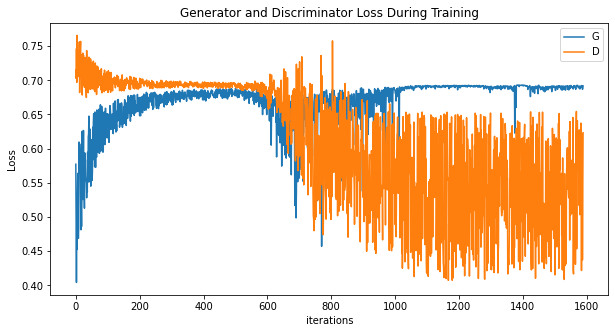

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [183]:
for i, (real_past_traj, real_future_traj) in enumerate(train_loader):
    # Format batch
    real_past_traj = real_past_traj.to(device)
    real_future_traj = real_future_traj.to(device)

    # Generate batch of latent vectors
    noise = torch.rand((real_past_traj.size(0),1,36,10), device=device)
    # Generate future traj batch with G
    fake = netG(real_past_traj, noise)
    break

In [186]:
fake[1,0,0]

tensor([-0.0869, -0.0773, -0.0903, -0.0803, -0.0811, -0.0771, -0.0719, -0.0226,
        -0.0797, -0.0760], device='cuda:0', grad_fn=<SelectBackward0>)

In [187]:
real_future_traj[1,0,0]

tensor([-0.2124, -0.2132, -0.2132, -0.2123, -0.2106, -0.2082, -0.2052, -0.2014,
        -0.1970, -0.1921], device='cuda:0')